## 0. Set environmental variables (Important!)

In [208]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 installation

In [209]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets albumentations

Liveloss plot utility to watch train/validation loss in realtime

In [211]:
!pip install livelossplot --quiet

In [212]:
!pip install onedrivedownloader nibabel google-cloud-storage MedPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [213]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.3 imports

In [214]:
import os
import random

import albumentations as A
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from datasets import load_dataset
from livelossplot import PlotLosses
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)
# Local imports
import utils.data_handler as dh
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(dh)
importlib.reload(mrp)
importlib.reload(metrics)

from utils.data_handler import DataHandler, MriType, StructuralScan
from utils.mri_plotter import MRIPlotter
np.set_printoptions(precision=16)


### 1.4 General functions

In [215]:
# helper functions
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

## get mask
def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

def softmax(logits):
    e_x = np.exp(logits - np.max(logits))
    return e_x / e_x.sum(axis=0)

def softmax_2d(logits):
    e_x = np.exp(logits - np.max(logits, axis=(0, 1), keepdims=True))
    return e_x / np.sum(e_x, axis=(0, 1), keepdims=True)

### 1.5 Data loaders
We define here how to organize data into the input format for maskformer

In [216]:
# Dataloader for the MRI dataset
class CustomMRIDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset_type: MriType, data_list_fn, processor, transform=None, augment=None):
        """
        Args:
            dataset
        """
        # valid: TRAIN_2D, VAL_2D, TRAIN_2d_CROSS, VAL_2D_CROSS
        self.mri_type = dataset_type
        self.processor = processor
        self.transform = transform
        self.augment = augment

        # load the file into a list
        self.data_handler = DataHandler(enable_gstorage=False)
        self.data_list = self.data_handler.load_text(file_name = data_list_fn)
        self.n_data = len(self.data_list)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):

        if idx >= self.n_data:
            print("warning: given index",idx,"does not exist in data. Using firs sample instead.")

        # find a file corresponding to idx
        item = None
        try:
          item = self.data_list[idx]
        except IndexError:
          item = self.data_list[0]

        subj_no = item.split('.')[0].split('_')[0]
        file_no = item.split('.')[0].split('_')[1]
        # print("Subj no", subj_no)
        # print("File no", file_no)
        # load data file to image and instance_seg
        # return nifti=True to return format before converting to numpy get_fdata

        data_cur, data_cur_nifti = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type,
                                              struct_scan = StructuralScan.FLAIR, return_nifti=True)
        n_h = data_cur_nifti.shape[0]
        n_w = data_cur_nifti.shape[1]
        image = np.zeros( (n_h, n_w, 3) )

        # convert data range from [0 1] to [0 255]
        image[:,:,0] = data_cur * 255
        # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1)
        image[:,:,1] = data_cur * 255

        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type, struct_scan = StructuralScan.T1GD)
        image[:,:,2] = data_cur * 255

        # load segm file
        data_cur = self.data_handler.load_mri(subj_id = subj_no, file_no=file_no, mri_type = self.mri_type)
        instance_seg =  np.zeros( (n_h, n_w), dtype='uint8')
        instance_seg[:,:] = data_cur.astype('uint8')
        # print(instance_seg.max())
        # currently set mapping manually
        mapping_dict = {}
        mapping_dict[0] = 0
        mapping_dict[1] = 1
        mapping_dict[2] = 2
        # mapping_dict[3] = 4
        mapping_dict[4] = 4

        # Use NumPy's vectorize() function to apply the mapping function to each element in the original array
        class_id_map = np.vectorize(lambda x: mapping_dict[x])(instance_seg)
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply data augmentation
        if self.augment is True:

            # # Image Color Jittering
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())
            pil_image = Image.fromarray(image.astype(np.uint8))
            color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            pil_image = color_jitter(pil_image)
            image = np.array(pil_image)
            # print("image mean, max=",image[:,:,0].mean(), image[:,:,0].max())

            # convert to C, H, W (torchvision transforms assume this shape)
            image = image.transpose(2,0,1)
            n1_tmp = instance_seg.shape[0]
            n2_tmp = instance_seg.shape[1]
            instance_seg = instance_seg.reshape((1,n1_tmp,n2_tmp))

            # convert to tensors
            image = torch.from_numpy(image.astype('float'))
            instance_seg = torch.from_numpy(instance_seg)
            # print("image mean, max=",image[0,:,:].mean(), image[0,:,:].max())

            # Apply random horizontal flip to image and mask
            if np.random.random() > 0.5:
                image = TF.hflip(image)
                instance_seg = TF.hflip(instance_seg)

            # Apply random crop to both the image and mask (as tensors)
            factor1 = 0.8
            if random.random() > 0.2:
                chance1 = random.choice([0,1,2,3,4])
                dim1 = image.shape
                # print('Original image dimension:',dim1,'choice:',chance1)
                if chance1 == 0: #upper left
                    image        =        image[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),:int(dim1[2]*factor1)]
                elif chance1 == 1: #upper right
                    image        =        image[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,:int(dim1[1]*factor1),int(dim1[2]*(1-factor1)):]
                elif chance1 == 2: #lower right
                    image        =        image[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,int(dim1[2]*(1-factor1)):]
                elif chance1 == 3: #lower left
                    image        =        image[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)):,:int(dim1[2]*factor1)]
                else: # center
                    image        =        image[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]
                    instance_seg = instance_seg[:,int(dim1[1]*(1-factor1)*0.5):int(dim1[1]*(1+factor1)*0.5), \
                                                  int(dim1[2]*(1-factor1)*0.5):int(dim1[2]*(1+factor1)*0.5)]

            #change back to ndarray
            image = image.numpy()
            instance_seg = instance_seg.numpy()
            instance_seg = instance_seg[0,:,:]

            # convert to H, W, C (transform requires this)
            image = image.transpose(1,2,0)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())

            # # remove labels not in the transformed segmentation map
            # inst_remove = {}
            # for instance in inst2class.keys():
            #     if not np.any(np.isin(instance_seg, instance)):
            #         inst_remove[instance] = 0
            # inst2class_new = {k: v for k, v in inst2class.items() if k not in inst_remove}
            # inst2class.update(inst2class_new)

            # # handle possible instance 0 that is created in transform
            # if instance_seg.min() == 0 and 0 not in inst2class:
            #     inst2class[0] = 0

            # print("inst2class after transform  :", inst2class)
            # print("instance_seg after transform:", np.unique(instance_seg))

        # apply input transforms, including resize (after cropping)
        if self.transform:
            transformed = self.transform(image=image, mask=instance_seg)
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

            image, instance_seg = transformed['image'], transformed['mask']
            # print("image mean, min, max=",image[:,:,0].mean(), image[:,:,0].min(), image[:,:,0].max())
            # print("instance_seg mean, min, max=",instance_seg[:,:].mean(), instance_seg[:,:].min(), instance_seg[:,:].max())

        # Prepare data to fit Maskformer input
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs


## 2. Process 2D data

### 2.2 make a data list file

In [217]:
# Reusable functions
def get_subj_ids(subj_files):
    # get unique subj train ids: [0001, 0002, 0003 ..]
    subj_ids = []
    for subj in subj_files:
        subj_id = data_handler.get_mri_subj_id(subj)
        if subj_id not in subj_ids:
            subj_ids.append(subj_id)
    return subj_ids

def get_subset_files(subj_files, subj_ids):
    # filter files within range
    subj_filenames = []
    for file_name in subj_files:
        subj_id = data_handler.get_mri_subj_id(file_name)
        subj_idx = subj_ids.index(subj_id)
        file_no = data_handler.get_mri_file_no(file_name)
        if file_no >= file_no_min and file_no < file_no_max and subj_idx >= subj_id_min and subj_idx < subj_id_max:
            subj_filename = data_handler.get_mri_subj_file(file_name)
            # item has to be unique
            if subj_filename not in subj_filenames:
                subj_filenames.append(subj_filename)
    subj_filenames.sort()
    return subj_filenames


In [218]:
# set directories
train_list_full = "data_train_all.txt"
val_list_full   = "data_val_all.txt"
train_list = "data_train.txt"
val_list   = "data_val.txt"

data_handler = DataHandler(enable_gstorage=True)
# old functionality
# ! ls $train_dir > $train_list_full
# ! ls $val_dir   > $val_list_full

#### Using below if use all data

In [219]:
# train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D_CROSS)
# train_files_unique = [data_handler.get_mri_subj_file(file_name) for file_name in train_2d]
# train_files_unique = list(set(train_files_unique))
# train_files_unique.sort()
# print(f"Number of unique training samples: {len(train_files_unique)}")
# data_handler.save_from_text(file_name = train_list,
#                             data='\n'.join(str(item) for item in train_files_unique))


# val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D_CROSS)
# val_files_unique = [data_handler.get_mri_subj_file(file_name) for file_name in val_2d]
# val_files_unique = list(set(val_files_unique))
# val_files_unique.sort()
# print(f"Number of unique validation samples: {len(val_files_unique)}")
# data_handler.save_from_text(file_name = val_list,
#                             data='\n'.join(str(item) for item in val_files_unique))

#### **Testing:** Using a small portion of data for efficient testing

In [220]:
# list files
train_2d = data_handler.list_mri_in_dir(mri_type=MriType.TRAIN_2D)
val_2d = data_handler.list_mri_in_dir(mri_type=MriType.VAL_2D)

# save as text file
data_handler.save_from_text(file_name = train_list_full, data='\n'.join(str(item) for item in train_2d))
data_handler.save_from_text(file_name = val_list_full, data='\n'.join(str(item) for item in val_2d))

In [221]:
# selecting slice range
n_total = 146
file_no_min = n_total//2
file_no_max = n_total//2 + 1
# file_no_min = 0
# file_no_max = n_total + 1

# selecting patent id range
subj_total = 88
subj_id_min = 0
subj_id_max = 1
# subj_id_min = 0
# subj_id_max = subj_total + 1

# Define train and validation dataset
# obtain all train subject ids
subj_train_files = data_handler.load_text(train_list_full)
subj_train_ids = get_subj_ids(subj_train_files)

train_files_unique_c = get_subset_files(subj_train_files, subj_train_ids)
print(f"Number of unique training samples: {len(train_files_unique_c)}")
data_handler.save_from_text(file_name = train_list,
                            data='\n'.join(str(item) for item in train_files_unique_c))

# do same for validation
subj_val_files = data_handler.load_text(val_list_full)
subj_val_ids = get_subj_ids(subj_val_files)
val_files_unique_c = get_subset_files(subj_val_files, subj_val_ids)
print(f"Number of unique validation samples: {len(val_files_unique_c)}")
data_handler.save_from_text(file_name = val_list, data='\n'.join(str(item) for item in val_files_unique_c))

Number of unique training samples: 1
Number of unique validation samples: 1


### 2.3 Create Custom PyTorch Dataset


In [222]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [223]:
# create train/validation datasets

# use the same mean and std as training set
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# define data transoforms
train_transform = A.Compose([
    # A.Resize(width=146, height=193),
    # A.Resize(width=193, height=163),
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# create datasets
train_dataset = CustomMRIDataset(MriType.TRAIN_2D, data_list_fn=train_list, processor=processor, transform=train_transform, augment=False)
val_dataset = CustomMRIDataset(MriType.VAL_2D, data_list_fn=val_list, processor=processor, transform=train_transform, augment=False)

In [224]:
# setup data loader
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [225]:
# make label dictionary
id2label = dh.SEGMENTS
print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 4: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 4}


### QC dataset

In [226]:
# peek at the dataset

inputs = train_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
1
tensor([0, 1, 2, 4])


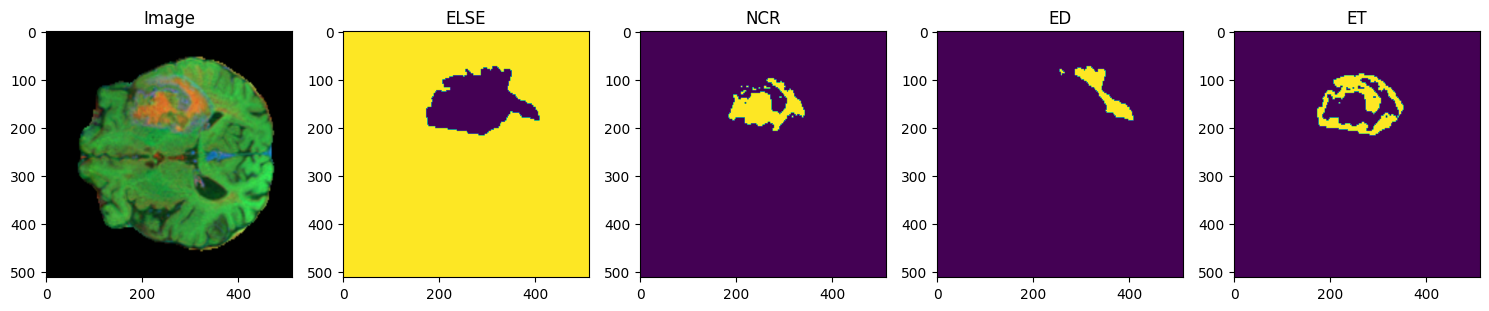

In [227]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, id in enumerate(inputs["class_labels"]):
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

In [228]:
# peek at the dataset

inputs = val_dataset[0]
for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(inputs["class_labels"])
# print(inputs)


pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])
1
tensor([0, 1, 2, 4])


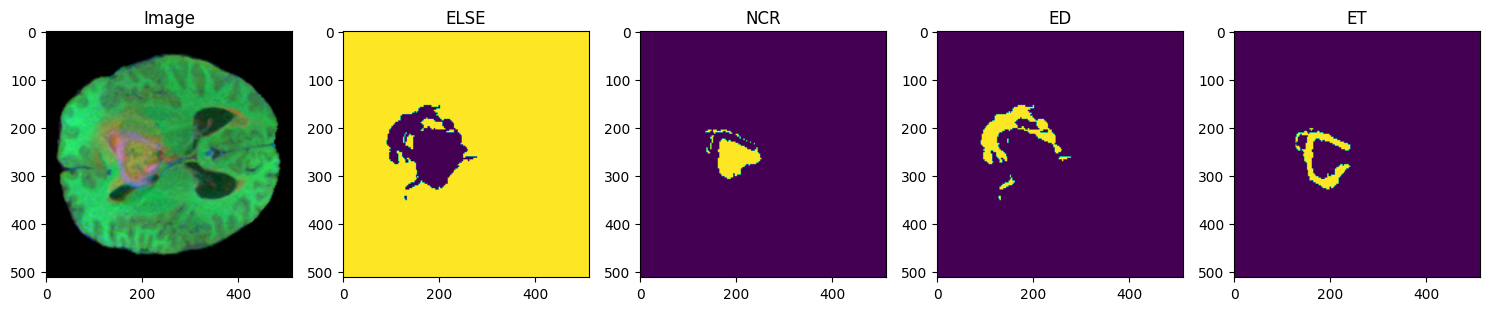

In [229]:
## visualize input image and masks
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( inputs['pixel_values'].numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, id in enumerate(inputs["class_labels"]):
    visual_mask = (inputs['mask_labels'][mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()

## 3. Fine-tuning Model

### 3.1 Define the model

In [230]:
# load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# print model config
configuration = model.config
# print(configuration)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [231]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, 512, 512), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [1, 3, 512, 512]     [1, 8, 100, 100]     --                   True
├─MaskFormerModel (model)                                                                       [1, 3, 512, 512]     [1, 8, 100, 100]     --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [1, 3, 512, 512]     --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [1, 3, 512, 512]     [1, 128, 128, 128]   86,882,424           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [1, 128, 128, 128]   --                   4,951,808            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [232]:
# # load saved model if needed
# model = torch.load('model/model_current.pt')

In [233]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print(outputs.loss)


pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
class_labels 1
mask_labels 1
[torch.Size([4])]
[torch.Size([4, 512, 512])]
tensor([3.3022], grad_fn=<AddBackward0>)


### Visualize initial model (Optional)

In [234]:
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([1, 100, 5])
masks_queries_logits shape: torch.Size([1, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([1, 1024, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([1, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([1, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([1, 8, 100, 100])


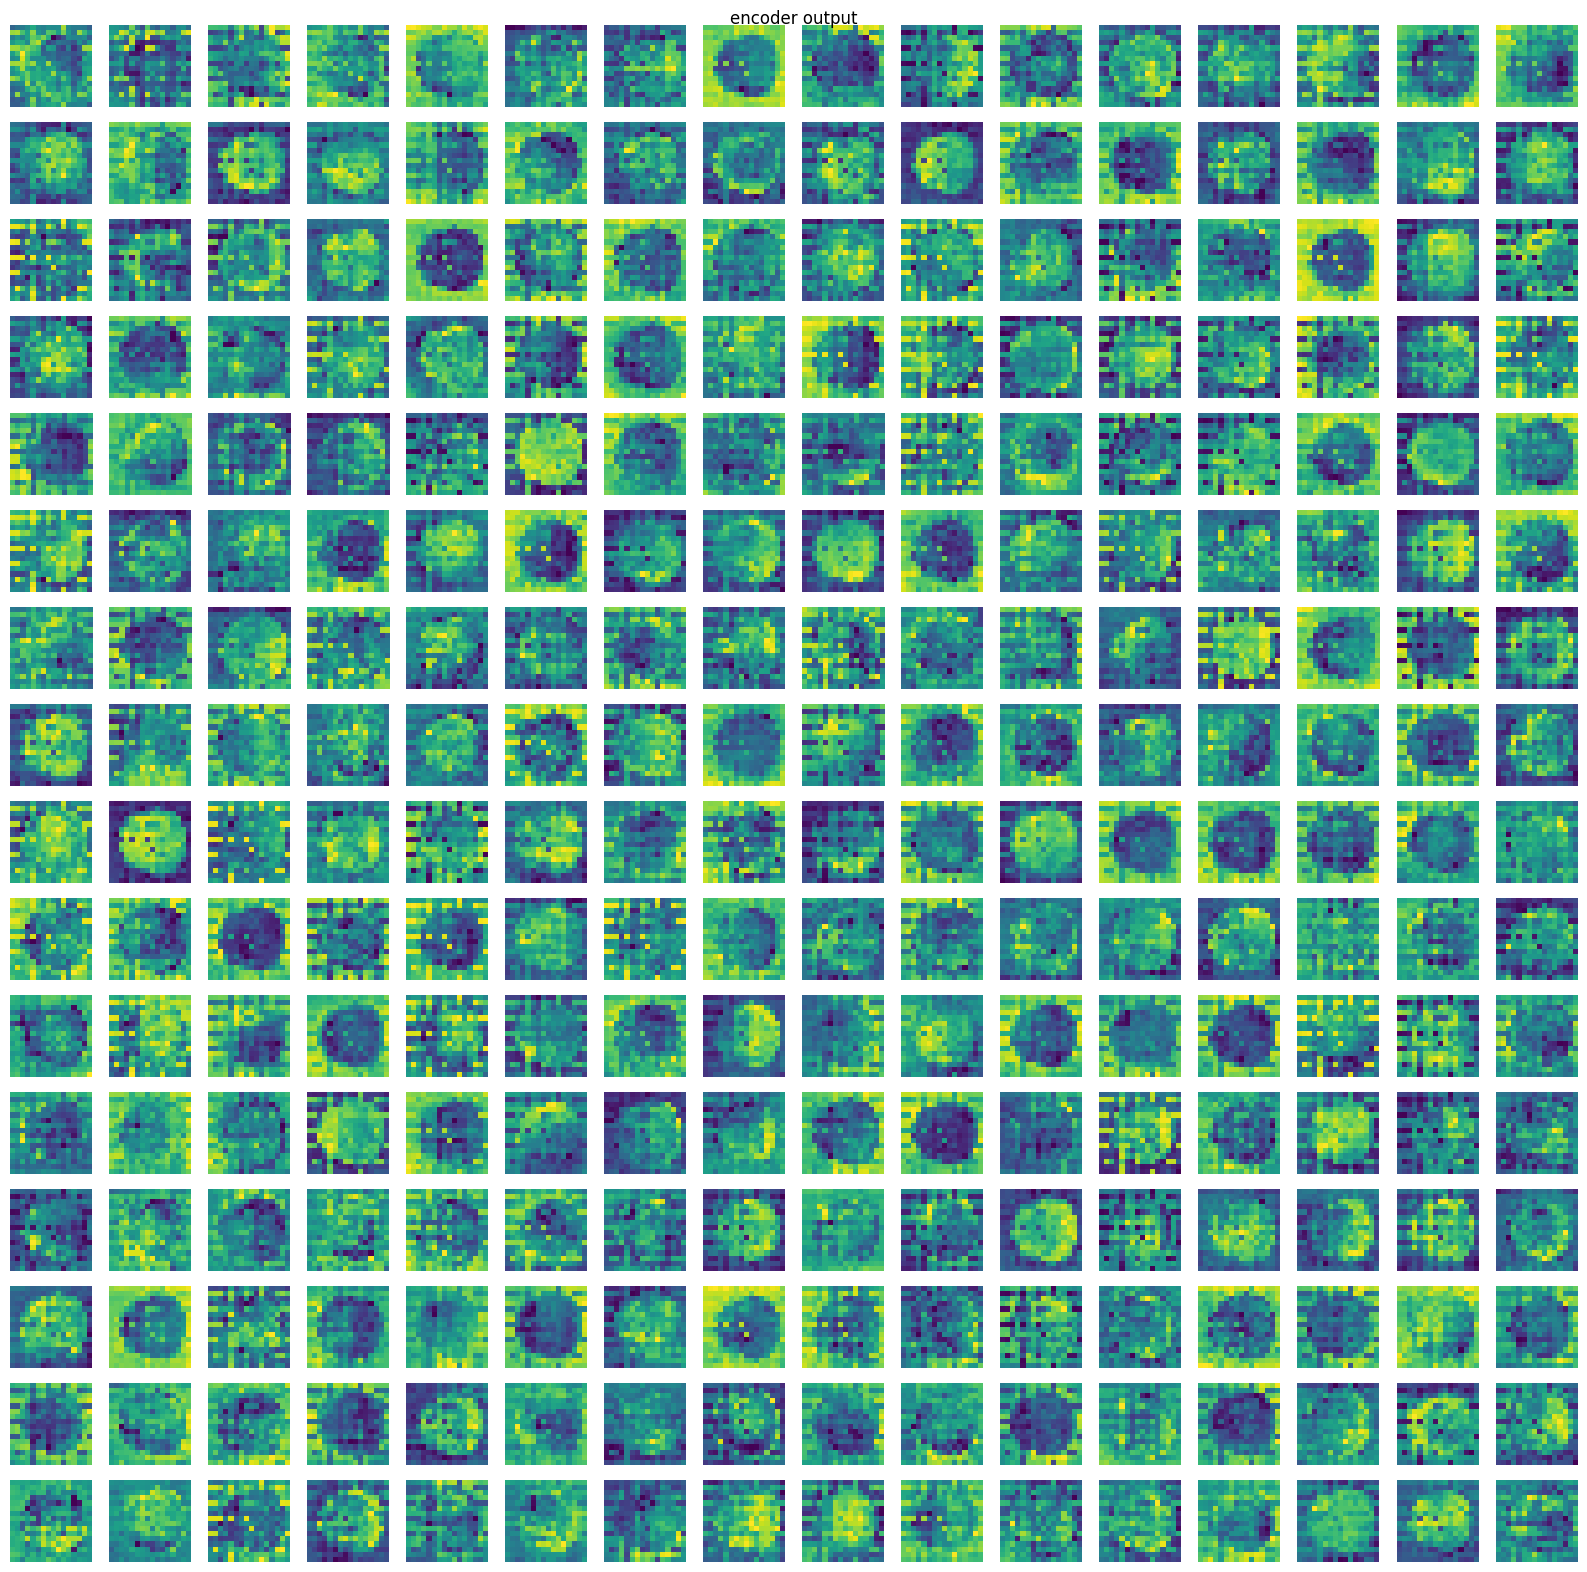

In [235]:
n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [236]:
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

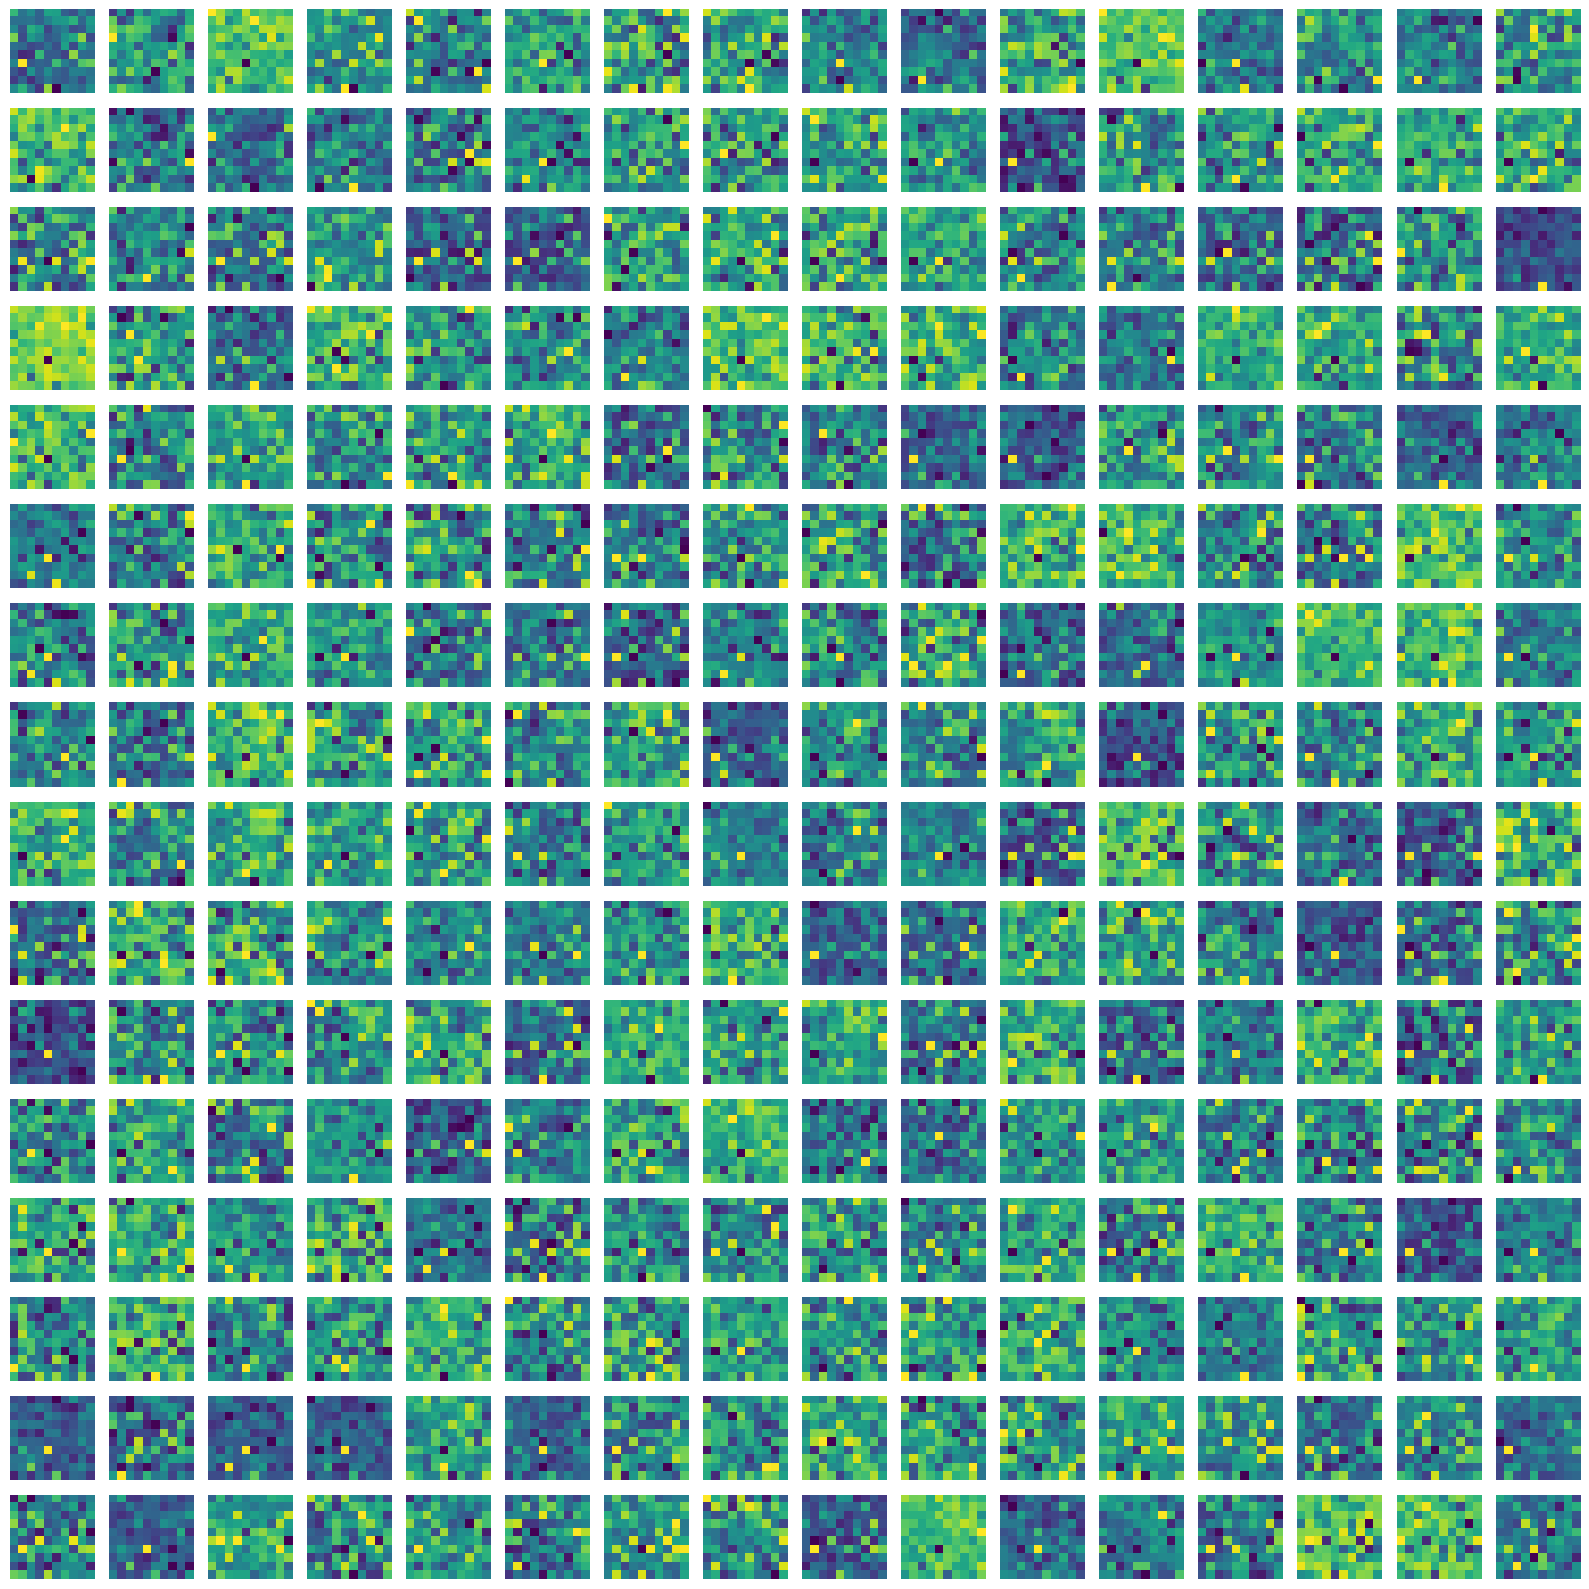

In [237]:
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,:,idx].detach().cpu().numpy().reshape((10,10))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()


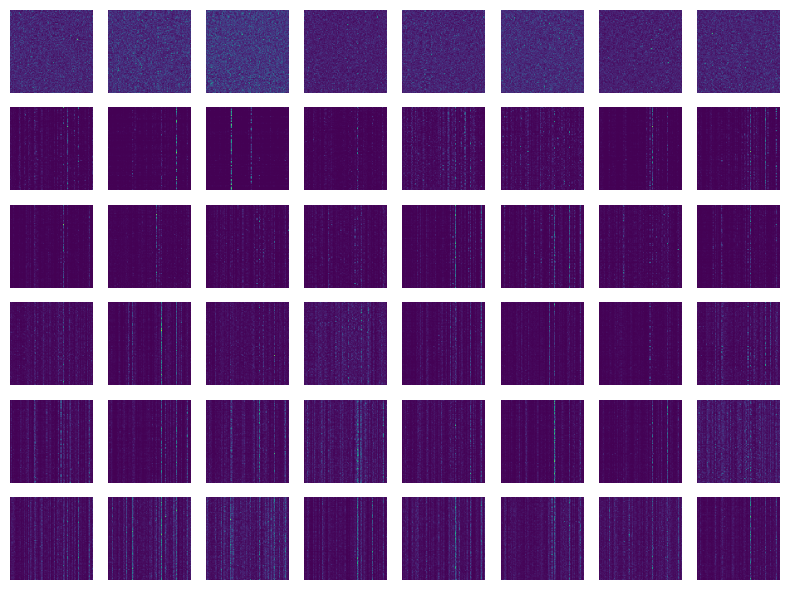

In [238]:
n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

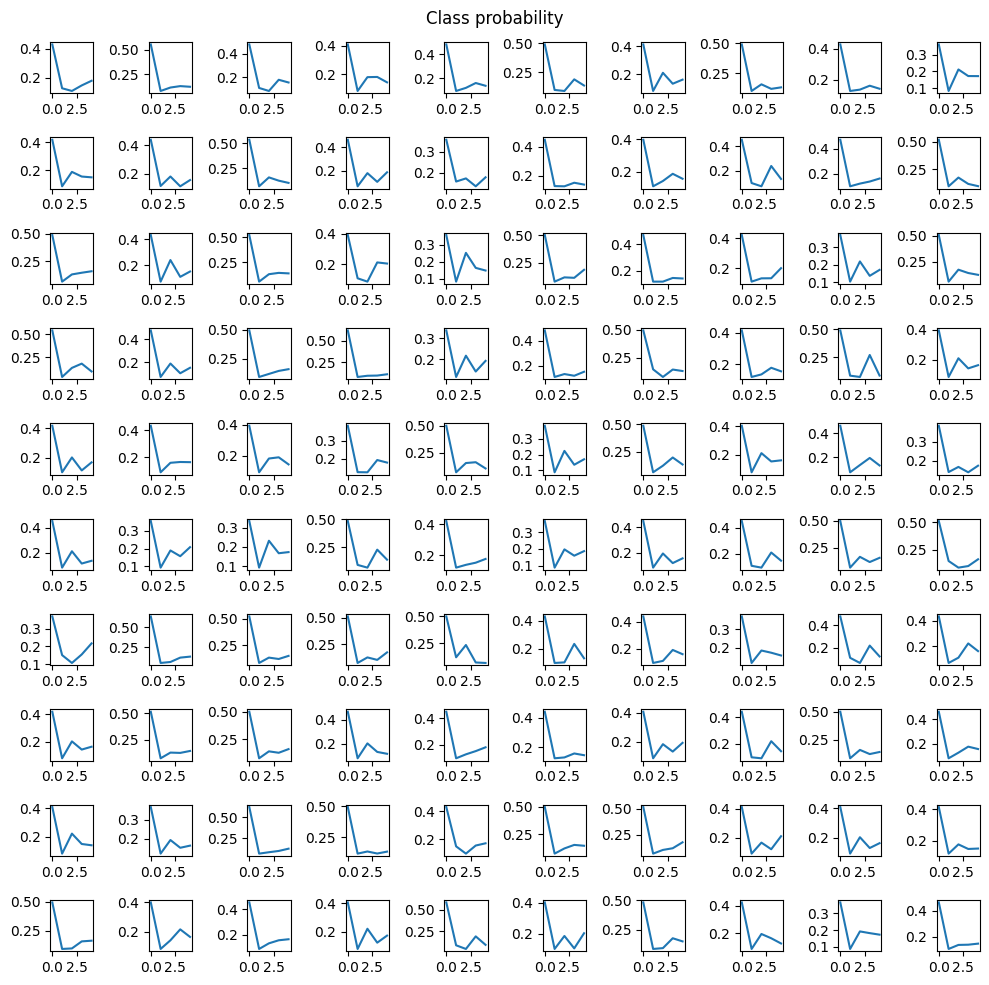

In [239]:
n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()
        probabilities = softmax(class_queries_logits_test)

        axs[irow,icol].plot(probabilities)
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

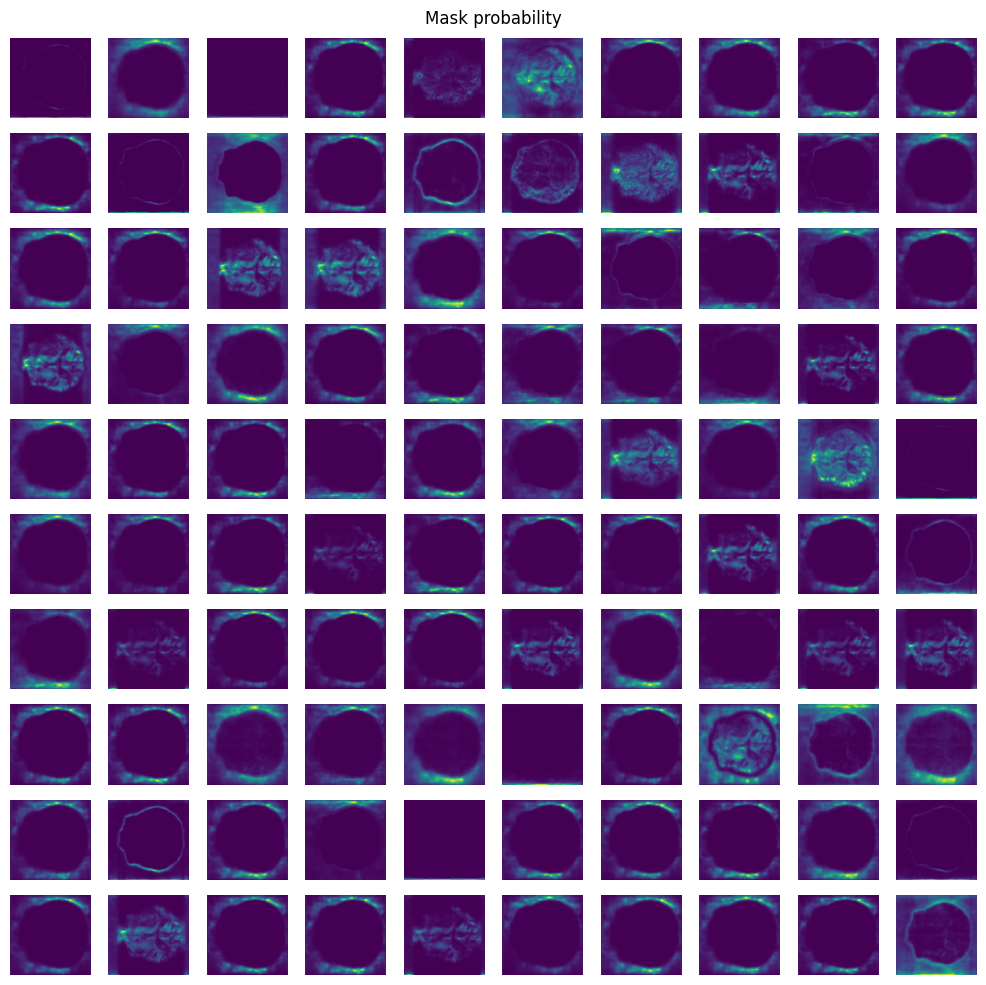

In [240]:
n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        masks_queries_logits_test = outputs.masks_queries_logits[0,idx,:,:].squeeze().detach().cpu().numpy()
        probabilities = softmax(masks_queries_logits_test)

        axs[irow,icol].imshow(probabilities)
        axs[irow,icol].axis('off')

fig.suptitle('Mask probability')
fig.tight_layout()
fig.show()


### 3.3 Train the model

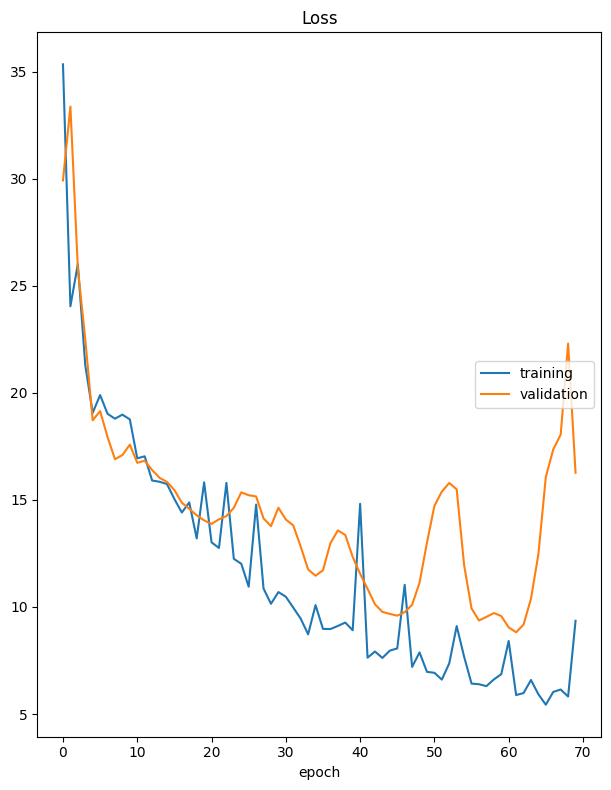

In [ ]:
# training
liveloss = PlotLosses()

def torch_save(model, file_name):
  # data handler will take care of directory for consistency across all models.
  # just need to supply it with the filename that we want
  temp_file_path = data_handler.create_temp_file(file_name)
  torch.save(model, temp_file_path)
  # upload to google storage or runtime
  data_handler.save_from_source_path(file_name, source_path=temp_file_path, upload_to_cloud=True)

n_epoch = 100
batch_max = 100000
loss_train = []
loss_val = []
min_loss = 1e9
# mutiplier is used to scale loss values to be more readable
loss_multiplier = 10.0

lr = 10e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)) )
logs = {}
# logs['loss'] = loss_init
# logs['val_loss'] = loss_init

# liveloss.update(logs)
# liveloss.send()

for epoch in range(1,n_epoch+1):
    print("Starting Epoch:", epoch)

    ## training loop
    running_loss = 0.0
    num_samples = 0
    model.train()
    for ibatch, batch in enumerate(tqdm(train_dataloader)):
        # run partial data based on input limit
        if ibatch < batch_max:
            # Reset the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                    pixel_values=batch["pixel_values"].to(device),
                    mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                    class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )

            # Backward propagation
            loss = outputs.loss * loss_multiplier
            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size
            loss_train_cur = running_loss/num_samples

            # Optimization
            optimizer.step()
        else:
            # skip where ibatch >= batch_max
            break

    # record loss at the end of each epoch
    logs['loss'] = loss_train_cur
    print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
    loss_train.append(loss_train_cur)

    ## validation loop
    running_loss = 0.0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for ibatch, batch in enumerate(tqdm(val_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # loss
                loss = outputs.loss  * loss_multiplier

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_val_cur = running_loss/num_samples
            else:
                # skip where ibatch >= batch_max
                break

    # record loss at the end of each epoch
    logs['val_loss'] = loss_val_cur
    # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
    loss_val.append(loss_val_cur)

    # if found better model, update min_loss and save model (currently using training loss)

    if min_loss > loss_val_cur:
        print("Saved model in epoch",epoch)
        # save the best model
        torch_save(model, "model_current.pt")
        min_loss = loss_val_cur

    # save model regularly
    if epoch%50 == 0:
        print("Saved model in epoch",epoch)
        # save the best model
        torch_save(model, 'model_epoch'+str(epoch)+'.pt')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()

# save loss at the end
torch_save(loss_train, 'losses_train_current.pt')
torch_save(loss_val, 'losses_val_current.pt')


### Visualizate final model (Optional)

In [ ]:
# obtain a batch of data
batch = next(iter(train_dataloader))

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )
loss_init = outputs.loss.item()

# print basic info
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

# print some info
print([label.shape for label in batch["class_labels"]])
print([label.shape for label in batch["mask_labels"]])

# print loss
print(outputs.loss)


In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


In [ ]:
# visualize the last layer of the encoder

n_row = 32
n_col = 32
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [ ]:
# visualize the last layer of the pixel decodeer

n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

In [ ]:
# visualize the last layer of the transformer decodeer

n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        decoder_last_test =  outputs.transformer_decoder_last_hidden_state[0,:,idx].detach().cpu().numpy().reshape((10,10))
        axs[irow,icol].imshow(decoder_last_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

In [ ]:
#visualize the attention map

n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

In [ ]:
# visualize class probability prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        probabilities = softmax(class_queries_logits_test)

        axs[irow,icol].plot(probabilities)
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# visualize mask probability prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        masks_queries_logits_test = outputs.masks_queries_logits[0,idx,:,:].squeeze().detach().cpu().numpy()

        probabilities = softmax_2d(masks_queries_logits_test)

        img = axs[irow,icol].imshow(probabilities)
        axs[irow,icol].axis('off')
        # fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask probability')
fig.tight_layout()
fig.show()


In [ ]:
print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

In [ ]:
# convert mask probability for mask probabilities for each class
masks_queries_probabilities = softmax_2d(outputs.masks_queries_logits.squeeze().permute(1,2,0).detach().cpu().numpy())
class_queries_probabilities = softmax(outputs.class_queries_logits.squeeze().permute(0, 1).detach().cpu().numpy())

print(masks_queries_probabilities.shape)
print(class_queries_probabilities.shape)

# Reshape array1 for matrix multiplication
reshaped_array = masks_queries_probabilities.reshape(128*128, 100)

# Perform matrix multiplication
test_tensor = np.matmul(reshaped_array, class_queries_probabilities)

# Reshape result to the desired shape
test_tensor = test_tensor.reshape(128, 128, 5)

test_tensor.shape

In [ ]:
# visualize mask probabilities for each class

n_col = 5

fig, axs = plt.subplots(nrows=1, ncols=n_col, figsize=(3*n_col, 3*1))  # Create subplots grid

for icol in range(n_col):
    test_tensor_plt = test_tensor[:,:,icol]

    img = axs[icol].imshow(test_tensor_plt)
    axs[icol].axis('off')
    fig.colorbar(img, ax=axs[icol])

# fig.suptitle('Mask probability')
fig.tight_layout()
fig.show()

In [ ]:
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state.squeeze().detach().cpu().numpy().reshape(256, 128*128)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state.squeeze().detach().cpu().numpy().reshape(100, 256)

# Perform matrix multiplication
mask_pred = np.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Reshape result to the desired shape
mask_pred = mask_pred.reshape(100, 128, 128)

test_tensor.shape

In [ ]:
# visualize mask prediction

n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred[idx,:,:])
        axs[irow,icol].axis('off')
        # fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


## 4. Evaluation

### 4.1 Model prediction QC



In [ ]:
# create a test data loader without shuffling
train_dataloader_test = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# obtain one batch of data

target_batch = 0

for ibatch, batch in enumerate(train_dataloader_test):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

test_idx = 0

test_image      =  test_batch["pixel_values"][test_idx]
test_pixel_mask =  test_batch["pixel_mask"][test_idx]
test_mask_label =  test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]

print(test_image.shape)
print(test_pixel_mask.shape)
print(test_mask_label.shape)
print(test_class_labels)

In [ ]:
# Visualize input data

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

print( np.array(test_image).shape )
n_image = len(inputs["class_labels"]) + 1

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

unnormalized_image = ( test_image.numpy() * np.array(ADE_STD)[:, None, None] ) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = ( unnormalized_image * 255 ).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

axs[0].imshow(unnormalized_image)
axs[0].set_title(f"Image")

for mask_idx, id in enumerate(test_class_labels):
    visual_mask = (test_mask_label[mask_idx].bool().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(visual_mask)
    axs[mask_idx+1].imshow(img)
    axs[mask_idx+1].set_title(f"{id2label[id.item()]}")  # Set a title for the subplot

plt.tight_layout()
plt.show()


In [ ]:
# load one batch of data and make predictions

batch = next(iter(train_dataloader))
batch["pixel_values"].shape

model.to(device)

outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

del batch
torch.cuda.empty_cache()

# post-processing of output
results = processor.post_process_instance_segmentation(outputs, target_sizes=[transforms.ToPILImage()(test_image).size[::-1]])[0]

print(results['segments_info'])
print(test_image.shape)
print(results['segmentation'].shape)

In [ ]:
# Obtain labels in true, predict, intersection and union

labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )
# remove duplicates
labels_pred = list(set(labels_pred))

labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:",labels_all)
print("Common labels:",labels_common)

In [ ]:
# visual QC predicted masks

n_image = len(labels_pred)

fig, axs = plt.subplots(nrows=1, ncols=n_image, figsize=(3*n_image, 3))  # Create subplots grid

for mask_idx, label in enumerate(labels_pred):
    mask_pred = np.zeros((results['segmentation'].shape[0],results['segmentation'].shape[1]))

    # find information in results
    id = label2id[label]
    for item in results['segments_info']:
        if item['label_id'] == id:
            segment = item
            mask_pred += np.array( get_mask(results['segmentation'], segment['id']) )

    mask_pred = mask_pred.astype(np.uint8)

    print("Visualizing mask for instance:", id2label[id])
    print("label_id is:", id )

    axs[mask_idx].imshow(mask_pred)
    axs[mask_idx].set_title(f"{label}")  # Set a title for the subplot

plt.tight_layout()
plt.show()


## Back-up